In [1]:
import pandas as pd
import sqlite3
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pickle
from model_utils import prepare_df, DetectLang
from sklearn.multioutput import MultiOutputClassifier
from tempfile import mkdtemp

In [2]:
conn = sqlite3.connect('../data/data_for_ml.db')
df = pd.read_sql('SELECT * FROM messages', con=conn)
conn.close()
# df = df.sample(frac=0.5)  # use a smaller dataset for this
df_train, df_test, cols = prepare_df(df)

In [3]:
cols

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

### set up the pipeline and do some grid search

In [4]:
pipe_cachedir = mkdtemp()

vec_transformer = Pipeline([
    ('vec', CountVectorizer(tokenizer=str.split,
                            token_pattern=None,
                            lowercase=False)),
    ('tfidf', TfidfTransformer())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('message', vec_transformer, 'message'),
        ('original', DetectLang(), 'original')
    ]
)

# it's better to use multioutputclassifier here
# rf alone can only use accuracy as scoring in multilabel task, which is not very useful
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', n_jobs=2)))
], memory = pipe_cachedir)

In [5]:
pipeline.get_params()

{'memory': '/var/folders/h9/t5gv56tx3wl0wk4czyrvf36m0000gn/T/tmpsk_2n7bt',
 'steps': [('preprocess',
   ColumnTransformer(transformers=[('message',
                                    Pipeline(steps=[('vec',
                                                     CountVectorizer(lowercase=False,
                                                                     token_pattern=None,
                                                                     tokenizer=<method 'split' of 'str' objects>)),
                                                    ('tfidf',
                                                     TfidfTransformer())]),
                                    'message'),
                                   ('original', DetectLang(), 'original')])),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                          n_jobs=2)))],
 'verbose': False,
 'preprocess': ColumnTransformer(transformers=[('mess

In [6]:
param_grid = {
    'preprocess__message__vec__min_df': [2,5,10],
    'preprocess__message__tfidf': [TfidfTransformer(), 'passthrough'],
    'preprocess__original': [DetectLang(max_langs=5), DetectLang(max_langs=10), 'drop'],
    'clf__estimator__min_samples_leaf': [2,3,5]
}

In [7]:
gclf = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring=['f1_macro','accuracy'],
                    refit='f1_macro',
                    verbose=3,
                    cv=5)

In [8]:
gclf.fit(df_train, df_train[cols].values)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
restarting detectlang
[CV 1/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=DetectLang(); accuracy: (test=0.259) f1_macro: (test=0.407) total time= 1.3min
restarting detectlang
[CV 2/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=DetectLang(); accuracy: (test=0.266) f1_macro: (test=0.409) total time= 1.3min
restarting detectlang
[CV 3/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=DetectLang(); accuracy: (test=0.252) f1_macro: (test=0.404) total time= 1.3min
restarting detectlang
[CV 4/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=D

restarting detectlang
[CV 4/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.293) f1_macro: (test=0.421) total time= 1.5min
restarting detectlang
[CV 5/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.283) f1_macro: (test=0.411) total time= 1.5min
restarting detectlang
[CV 1/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.280) f1_macro: (test=0.406) total time=21.6min
restarting detectlang
[CV 2/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.295

restarting detectlang
[CV 3/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.255) f1_macro: (test=0.451) total time= 1.1min
restarting detectlang
[CV 4/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.269) f1_macro: (test=0.464) total time= 1.2min
restarting detectlang
[CV 5/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.251) f1_macro: (test=0.444) total time= 1.1min
[CV 1/5] END clf__estimator__min_samples_leaf=2, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=drop; accuracy: (test=0.261) f1_macro: (test=0.456) total time= 1.1min
[CV 2/

[CV 3/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=drop; accuracy: (test=0.235) f1_macro: (test=0.429) total time= 1.1min
[CV 4/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=drop; accuracy: (test=0.239) f1_macro: (test=0.443) total time= 1.1min
[CV 5/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=2, preprocess__original=drop; accuracy: (test=0.225) f1_macro: (test=0.431) total time= 1.1min
[CV 1/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=5, preprocess__original=DetectLang(); accuracy: (test=0.246) f1_macro: (test=0.436) total time= 1.2min
[CV 2/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=TfidfTransformer(), 

[CV 4/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=2, preprocess__original=DetectLang(); accuracy: (test=0.204) f1_macro: (test=0.467) total time=  53.8s
[CV 5/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=2, preprocess__original=DetectLang(); accuracy: (test=0.190) f1_macro: (test=0.454) total time=  53.2s
[CV 1/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=2, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.197) f1_macro: (test=0.448) total time=  53.6s
[CV 2/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=2, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.204) f1_macro: (test=0.455) total time=  53.1s
[CV 3/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=

[CV 5/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=10, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.225) f1_macro: (test=0.467) total time=  58.4s
[CV 1/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=10, preprocess__original=drop; accuracy: (test=0.237) f1_macro: (test=0.469) total time=  58.5s
[CV 2/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=10, preprocess__original=drop; accuracy: (test=0.241) f1_macro: (test=0.472) total time= 1.0min
[CV 3/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=10, preprocess__original=drop; accuracy: (test=0.234) f1_macro: (test=0.472) total time=  58.1s
[CV 4/5] END clf__estimator__min_samples_leaf=3, preprocess__message__tfidf=passthrough, preprocess__message

[CV 1/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.228) f1_macro: (test=0.457) total time= 1.1min
[CV 2/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.221) f1_macro: (test=0.458) total time= 1.1min
[CV 3/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.210) f1_macro: (test=0.454) total time= 1.1min
[CV 4/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=TfidfTransformer(), preprocess__message__vec__min_df=10, preprocess__original=DetectLang(); accuracy: (test=0.214) f1_macro: (test=0.461) total time= 1.1min
[CV 5/5] END clf__estimator__min_samples_leaf=5, preprocess__message

[CV 2/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.186) f1_macro: (test=0.442) total time=  46.4s
[CV 3/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.169) f1_macro: (test=0.453) total time=  46.7s
[CV 4/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.181) f1_macro: (test=0.454) total time=  46.2s
[CV 5/5] END clf__estimator__min_samples_leaf=5, preprocess__message__tfidf=passthrough, preprocess__message__vec__min_df=5, preprocess__original=DetectLang(max_langs=10); accuracy: (test=0.170) f1_macro: (test=0.458) total time=  46.4s
[CV 1/5] END clf__estimator__min_samples_leaf=5, pre

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/h9/t5gv56tx3wl0wk4czyrvf36m0000gn/T/tmpsk_2n7bt',
                                steps=[('preprocess',
                                        ColumnTransformer(transformers=[('message',
                                                                         Pipeline(steps=[('vec',
                                                                                          CountVectorizer(lowercase=False,
                                                                                                          token_pattern=None,
                                                                                                          tokenizer=<method 'split' of 'str' objects>)),
                                                                                         ('tfidf',
                                                                                          TfidfTransformer())]),
                                                                         'message'),
                                                                        ('original',
                                                                         DetectLan...
                                        MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                               n_jobs=2)))]),
             param_grid={'clf__estimator__min_samples_leaf': [2, 3, 5],
                         'preprocess__message__tfidf': [TfidfTransformer(),
                                                        'passthrough'],
                         'preprocess__message__vec__min_df': [2, 5, 10],
                         'preprocess__original': [DetectLang(),
                                                  DetectLang(max_langs=10),
                                                  'drop']},
             refit='f1_macro', scoring=['f1_macro', 'accuracy'], verbose=3)

In [9]:
gclf.cv_results_

{'mean_fit_time': array([ 76.97518158,  79.95459399,  79.4577518 ,  82.11328011,
         81.80538216,  81.88686147,  87.2505897 , 324.54435449,
         83.83617964,  63.1976933 ,  63.58023996,  62.58191295,
        345.42536054,  65.93901987,  72.62796011, 109.01943541,
        311.81962161,  67.99016523,  62.44488468,  63.39403186,
         63.33231635,  69.02082105,  75.32578745, 109.9205883 ,
         73.12504706,  73.76667762,  74.54173694,  51.42164979,
         51.41088309,  51.31584544,  54.19036002,  54.22313495,
         53.67305913,  56.86069345,  56.80344224,  57.02758231,
         53.08452663,  52.95537305,  53.45195389,  58.63076506,
         59.36934643,  59.99519706,  64.07119665,  63.68795485,
         63.59454341,  41.23516731,  42.31437984,  49.8017962 ,
         50.65979385,  45.5254601 ,  45.67880259,  48.05779848,
         50.3614192 ,  46.28493242]),
 'std_fit_time': array([1.76337488e+00, 1.49738205e+00, 9.74378478e-01, 6.07248808e-01,
        5.20530858e-01, 5

In [10]:
with open('test_preprocess.pickle','wb') as fid:
    pickle.dump(gclf, fid)

### analyze the cv result

In [22]:
from cv_result_analyzer import CVResultAnalyzer

In [21]:
import sys
del sys.modules['cv_result_analyzer']

In [27]:
analyzer = CVResultAnalyzer(targets=['total'],pickle_files=['test_preprocess.pickle'],score='f1_macro')

In [28]:
analyzer.display_topk(10)

id clf__estimator__min_samples_leaf preprocess__message__tfidf  \
target                                                                      
total  35  35                                3                passthrough   
       32  32                                3                passthrough   
       33  33                                3                passthrough   
       34  34                                3                passthrough   
       30  30                                3                passthrough   
       31  31                                3                passthrough   
       53  53                                5                passthrough   
       51  51                                5                passthrough   
       52  52                                5                passthrough   
       27  27                                3                passthrough   

          preprocess__message__vec__min_df      preprocess__original  \
target                                                                 
total  35                               10                      drop   
       32                                5                      drop   
       33                               10              DetectLang()   
       34                               10  DetectLang(max_langs=10)   
       30                                5              DetectLang()   
       31                                5  DetectLang(max_langs=10)   
       53                               10                      drop   
       51                               10              DetectLang()   
       52                               10  DetectLang(max_langs=10)   
       27                                2              DetectLang()   

           mean_fit_time  split0_test  split1_test  split2_test  split3_test  \
target                                                                         
total  35      57.027582     0.468899     0.471794     0.472390     0.481529   
       32      53.673059     0.472558     0.468660     0.472791     0.472775   
       33      56.860693     0.464976     0.470643     0.470085     0.476845   
       34      56.803442     0.464223     0.471372     0.470258     0.477357   
       30      54.190360     0.466186     0.462624     0.468835     0.477463   
       31      54.223135     0.459618     0.464384     0.469415     0.471791   
       53      46.284932     0.464629     0.451115     0.462584     0.468099   
       51      48.057798     0.453784     0.451189     0.463561     0.463169   
       52      50.361419     0.459087     0.449764     0.459590     0.465943   
       27      51.421650     0.456815     0.448643     0.467099     0.467223   

           split4_test  mean_test  std_test target  
target                                              
total  35     0.471058   0.473134  0.004361  total  
       32     0.470143   0.471385  0.001688  total  
       33     0.470426   0.470595  0.003766  total  
       34     0.466966   0.470035  0.004442  total  
       30     0.470250   0.469072  0.004935  total  
       31     0.467743   0.466590  0.004239  total  
       53     0.457832   0.460852  0.005894  total  
       51     0.464227   0.459186  0.005542  total  
       52     0.459953   0.458867  0.005190  total  
       27     0.453730   0.458702  0.007383  total

In [29]:
analyzer.pivot_one_param(conds=[],
                         param='preprocess__message__tfidf',
                         index = ['clf__estimator__min_samples_leaf','preprocess__message__vec__min_df','preprocess__original'],
                         val='mean_test')

preprocess__message__tfidf                                                                  TfidfTransformer()  \
clf__estimator__min_samples_leaf preprocess__message__vec__min_df preprocess__original                           
2                                10                               DetectLang()                        0.411100   
                                                                  DetectLang(max_langs=10)            0.408488   
                                                                  drop                                0.408180   
                                 2                                DetectLang()                        0.408665   
                                                                  DetectLang(max_langs=10)            0.412642   
                                                                  drop                                0.413115   
                                 5                                DetectLang()                        0.411531   
                                                                  DetectLang(max_langs=10)            0.413111   
                                                                  drop                                0.410974   
3                                10                               DetectLang()                        0.441296   
                                                                  DetectLang(max_langs=10)            0.443433   
                                                                  drop                                0.445148   
                                 2                                DetectLang()                        0.432737   
                                                                  DetectLang(max_langs=10)            0.433465   
                                                                  drop                                0.434223   
                                 5                                DetectLang()                        0.439981   
                                                                  DetectLang(max_langs=10)            0.441666   
                                                                  drop                                0.440416   
5                                10                               DetectLang()                        0.456384   
                                                                  DetectLang(max_langs=10)            0.454223   
                                                                  drop                                0.457881   
                                 2                                DetectLang()                        0.432244   
                                                                  DetectLang(max_langs=10)            0.435636   
                                                                  drop                                0.440003   
                                 5                                DetectLang()                        0.449273   
                                                                  DetectLang(max_langs=10)            0.447936   
                                                                  drop                                0.449211   

preprocess__message__tfidf                                                                  passthrough  
clf__estimator__min_samples_leaf preprocess__message__vec__min_df preprocess__original                   
2                                10                               DetectLang()                 0.453510  
                                                                  DetectLang(max_langs=10)     0.451496  
                                                                  drop                         0.456125  
                                 2                                DetectLang()                 0.450139  
                                                         

#### in all cases, passthrough is better!

In [30]:
analyzer.pivot_one_param(conds=[('preprocess__message__tfidf', ['passthrough'])],
                         param='preprocess__message__vec__min_df',
                         index = ['clf__estimator__min_samples_leaf','preprocess__original'],
                         val='mean_test')

preprocess__message__vec__min_df                                 10         2  \
clf__estimator__min_samples_leaf preprocess__original                           
2                                DetectLang()              0.453510  0.450139   
                                 DetectLang(max_langs=10)  0.451496  0.450192   
                                 drop                      0.456125  0.453583   
3                                DetectLang()              0.470595  0.458702   
                                 DetectLang(max_langs=10)  0.470035  0.456327   
                                 drop                      0.473134  0.458553   
5                                DetectLang()              0.459186  0.439014   
                                 DetectLang(max_langs=10)  0.458867  0.440870   
                                 drop                      0.460852  0.444432   

preprocess__message__vec__min_df                                  5  
clf__estimator__min_samples_leaf preprocess__original                
2                                DetectLang()              0.455911  
                                 DetectLang(max_langs=10)  0.454293  
                                 drop                      0.454743  
3                                DetectLang()              0.469072  
                                 DetectLang(max_langs=10)  0.466590  
                                 drop                      0.471385  
5                                DetectLang()              0.452143  
                                 DetectLang(max_langs=10)  0.451016  
                                 drop                      0.454461

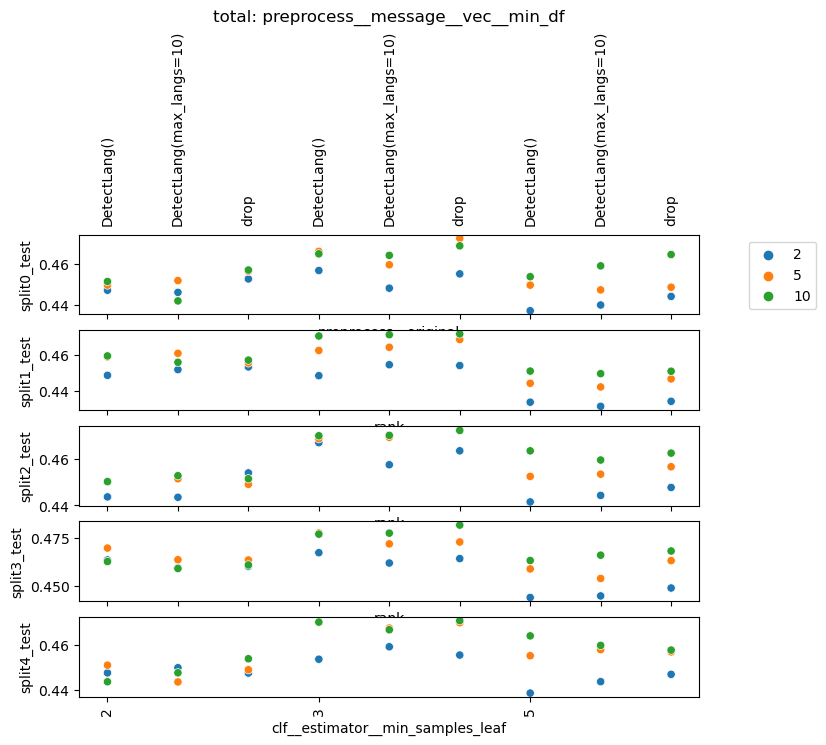

In [31]:
analyzer.scatterplot('total',
                     hue='preprocess__message__vec__min_df',
                     ys=[f'split{i}_test' for i in range(5)],
                     x_main='clf__estimator__min_samples_leaf',
                     x_secondary='preprocess__original',
                     conds = [('clf__estimator__min_samples_leaf', ['2','3','5']), 
                                ('preprocess__message__tfidf', ['passthrough'])])

In [32]:
analyzer.display_topk(10, conds=[('preprocess__message__tfidf', ['passthrough'])])

id clf__estimator__min_samples_leaf preprocess__message__tfidf  \
target                                                                      
total  35  35                                3                passthrough   
       32  32                                3                passthrough   
       33  33                                3                passthrough   
       34  34                                3                passthrough   
       30  30                                3                passthrough   
       31  31                                3                passthrough   
       53  53                                5                passthrough   
       51  51                                5                passthrough   
       52  52                                5                passthrough   
       27  27                                3                passthrough   

          preprocess__message__vec__min_df      preprocess__original  \
target                                                                 
total  35                               10                      drop   
       32                                5                      drop   
       33                               10              DetectLang()   
       34                               10  DetectLang(max_langs=10)   
       30                                5              DetectLang()   
       31                                5  DetectLang(max_langs=10)   
       53                               10                      drop   
       51                               10              DetectLang()   
       52                               10  DetectLang(max_langs=10)   
       27                                2              DetectLang()   

           mean_fit_time  split0_test  split1_test  split2_test  split3_test  \
target                                                                         
total  35      57.027582     0.468899     0.471794     0.472390     0.481529   
       32      53.673059     0.472558     0.468660     0.472791     0.472775   
       33      56.860693     0.464976     0.470643     0.470085     0.476845   
       34      56.803442     0.464223     0.471372     0.470258     0.477357   
       30      54.190360     0.466186     0.462624     0.468835     0.477463   
       31      54.223135     0.459618     0.464384     0.469415     0.471791   
       53      46.284932     0.464629     0.451115     0.462584     0.468099   
       51      48.057798     0.453784     0.451189     0.463561     0.463169   
       52      50.361419     0.459087     0.449764     0.459590     0.465943   
       27      51.421650     0.456815     0.448643     0.467099     0.467223   

           split4_test  mean_test  std_test target  
target                                              
total  35     0.471058   0.473134  0.004361  total  
       32     0.470143   0.471385  0.001688  total  
       33     0.470426   0.470595  0.003766  total  
       34     0.466966   0.470035  0.004442  total  
       30     0.470250   0.469072  0.004935  total  
       31     0.467743   0.466590  0.004239  total  
       53     0.457832   0.460852  0.005894  total  
       51     0.464227   0.459186  0.005542  total  
       52     0.459953   0.458867  0.005190  total  
       27     0.453730   0.458702  0.007383  total

In [33]:
f1_score(gclf.predict(df_test), df_test[cols].values, average='macro')

0.4727914245761501

In [35]:
gclf.best_params_

{'clf__estimator__min_samples_leaf': 3,
 'preprocess__message__tfidf': 'passthrough',
 'preprocess__message__vec__min_df': 10,
 'preprocess__original': 'drop'}

### these seems to be the best preprocess params